<iframe src="https://giphy.com/embed/ATsWtUsuuFRfq8OhZ7" width="480" height="330" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/transformer-vit-ATsWtUsuuFRfq8OhZ7">via GIPHY</a></p>

# importing libraries

In [1]:
import einops
from tqdm.notebook import tqdm
from torchsummary import summary
import time
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.utils.data as data
import torch.optim as optim
from torchvision import transforms

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# hyperparameters

In [3]:
CUDA=torch.cuda.is_available()
CUDA=False
device=torch.device("cuda:7" if CUDA else "cpu")
patch_size=16 
dim_head=768
n_channels=3
num_heads=12 # ViT-Base uses 12 heads
num_encoders_layers = 12       # ViT-Base uses 12 encoder layers
num_classes = 15        # Number of classes in CIFAR10 dataset
size = 224              # Size used for training = 224
epochs = 10             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base
batch_size = 8
dropout=0.1

# Dataset preparation and loader

In [4]:
# TRANSFORM_IMG = transforms.Compose([
#     transforms.RandomCrop(32, padding=4), 
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225] )
#     ])
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [5]:
dataset=torchvision.datasets.ImageFolder(root="/mnt/disk1/Gulshan/dataset/butterfly/Train",
                                               transform=TRANSFORM_IMG)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=4,drop_last=True)
val_loader = data.DataLoader(val_dataset, batch_size=8, shuffle=True,  num_workers=4)


In [6]:
x,y=next(iter(train_loader))
x.shape,y

(torch.Size([8, 3, 224, 224]), tensor([ 6, 10,  2,  0,  2,  1,  1,  3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'adonis': 0, 'red spotted purple': 1, 'scarce swallow': 2, 'silver spot skipper': 3, 'sixspot burnet': 4, 'skipper': 5, 'sootywing': 6, 'southern dogface': 7, 'straited queen': 8, 'two barred flasher': 9, 'ulyses': 10, 'viceroy': 11, 'wood satyr': 12, 'yellow swallow tail': 13, 'zebra long wing': 14}
silver spot skipper:3 zebra long wing:14 wood satyr:12 yellow swallow tail:13 straited queen:8 scarce swallow:2 wood satyr:12 silver spot skipper:3


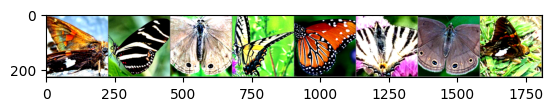

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(dataset.class_to_idx)
print(' '.join(f'{dataset.classes[j]}:{j}' for j in (labels)))
imshow(torchvision.utils.make_grid(images))

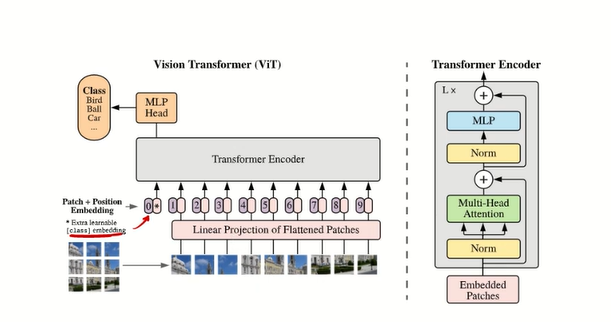

# Embedding

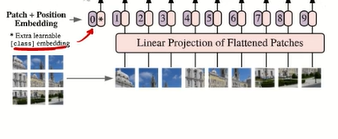

In [8]:
class ImageEmbedding(nn.Module):
    def __init__(self,patch_size=patch_size,dim_head=dim_head,n_channels=n_channels,batch_size=batch_size,device=device) -> None:
        super(ImageEmbedding,self).__init__()
        self.patch_size=patch_size
        self.dim_head=dim_head
        self.n_channels=n_channels
        self.batch_size=batch_size
        self.device=device
        self.input_size=patch_size*patch_size*n_channels # flttening the it ->16*16*3=768 
        
        self.linear_proj=nn.Linear(self.input_size,self.dim_head)
        #class token
        self.cls_token=nn.Parameter(torch.randn(self.batch_size,1,self.dim_head)).to(device)
        # Positional embedding
        self.postional_embedding=nn.Parameter(torch.randn(self.batch_size,1,self.dim_head)).to(device)
        
        
    def forward(self,input_data):
        input_data=input_data.to(device)
        # print("input shape",input_data.shape)#input shape torch.Size([1, 3, 224, 224]) -> (bs,c,h,w)
        
        #patchify
        patches=einops.rearrange(input_data,'b c (h h1) (w w1) -> b (h w) (h1 w1 c)',
            h1=self.patch_size,w1=self.patch_size)
        # print("patchify shape ->",patches.shape) #patchify shape -> torch.Size([1, 196, 768])
        # torch.Size([1, 196, 768]) -> (bs,num of patches per image,no of pixels in each patch)
        # patchify shape -> torch.Size([1, 196, 768]) -> (bs,(224*224)/16*16,16*16*3)
        
        #(224*224)/16*16=196,16*16*3=768 
        #here 768 has no connection with dim_head
        
        linear_proj=self.linear_proj(patches).to(self.device)
        # print("linear_proj.shape",linear_proj.shape)#linear_proj.shape torch.Size([8, 196, 768])
        b,no_patch,_=linear_proj.shape
        # adding class token along the dim 1 so no of patch would be 197        
        linear_proj=torch.cat((self.cls_token,linear_proj),dim=1)
        # print("linear_proj shape ->",linear_proj.shape) # linear_proj shape -> torch.Size([8, 197, 768])
        # now we need to match the shape of linear proj for postional embedding
        pos_embed=einops.repeat(self.postional_embedding,'b 1 d -> b m d',m=no_patch+1)
        # print("pos_embed shape ->",pos_embed.shape)#pos_embed shape -> torch.Size([8, 197, 768])
        final=linear_proj+pos_embed
        # print("final.shape ->",final.shape) # final.shape -> torch.Size([8, 197, 768])
        return final

In [9]:
x=torch.randn(batch_size,3,224,224)
test_class=ImageEmbedding()
t=test_class(x)

# Encoder

here there is no feed forward network instead we use multilayer perceptron

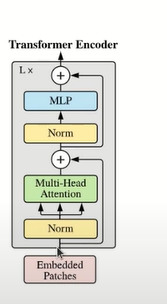

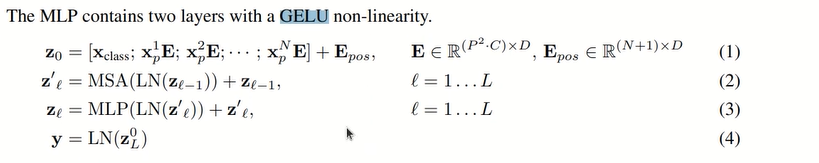

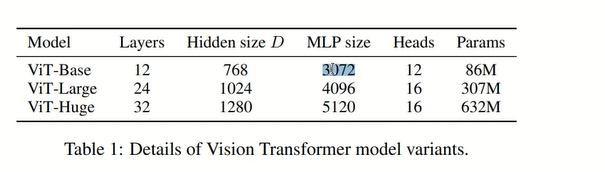

In [10]:
class encoderblock(nn.Module):
    def __init__(self,dim_head=dim_head,num_heads=num_heads,device=device,dropout=dropout) -> None:
        super(encoderblock,self).__init__()
        self.dim_head=dim_head
        self.num_heads=num_heads
        self.device=device
        self.dropout=dropout
        # layer norm
        self.layer_norm=nn.LayerNorm(dim_head)
        # not from sratch
        self.multihead=nn.MultiheadAttention(self.dim_head,
                                             self.num_heads,
                                             dropout=self.dropout)
        self.enc_mlp=nn.Sequential(
            nn.Linear(self.dim_head,self.dim_head*4),# 768 *4 = 3072
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.dim_head*4,self.dim_head),
            nn.Dropout(self.dropout),
        )
    def forward(self,embedded_patch):
        # print('embedded_patch shape',embedded_patch.shape)
        #embedded_patch shape torch.Size([8, 197, 768])
        first_nrom_out=self.layer_norm(embedded_patch)
        #first_nrom_out torch.Size([8, 197, 768])
        # print('first_nrom_out',first_nrom_out.shape)
        # multihead attn return a tuple -> attn_output ,attn_output weights
        attn_out=self.multihead(first_nrom_out,first_nrom_out,first_nrom_out)[0]
        #attn_out shape torch.Size([8, 197, 768])
        # print('attn_out shape',attn_out.shape)
        # first residual
        first_resi=attn_out+embedded_patch
        #first_resi shape torch.Size([8, 197, 768])
        # print('first_resi shape',first_resi.shape)
        second_nrom_out=self.layer_norm(first_resi)
        #second_nrom_out shape torch.Size([8, 197, 768])
        # print('second_nrom_out shape',second_nrom_out.shape)
        mlp_out=self.enc_mlp(second_nrom_out)
        #mlp_out shape torch.Size([8, 197, 768])
        # print('mlp_out shape',mlp_out.shape)
        out=mlp_out+first_resi
        #out shape torch.Size([8, 197, 768])
        # print('out shape',out.shape)
        return out

In [11]:
teset_en=encoderblock()
# teset_en(t)

put Everything togethere

In [12]:
class Vision_Tranformer(nn.Module):
    def __init__(self,num_encoders_layers=num_encoders_layers,dropout=dropout,dim_head=dim_head,device=device,num_classes=num_classes) -> None:
        super(Vision_Tranformer,self).__init__()
        self.num_encoders_layers=num_encoders_layers
        self.dropout=dropout
        self.dim_head=dim_head
        self.device=device
        self.num_classes=num_classes
        # intializew the image embedding class 
        self.imageembedding=ImageEmbedding()
        #create stack of encoders block
        self.encoder_stack=nn.ModuleList([encoderblock() for _ in range(self.num_encoders_layers)])
        # create a last MLP
        self.mlp=nn.Sequential(
            nn.LayerNorm(self.dim_head),
            nn.Linear(self.dim_head,self.dim_head),
            nn.Linear(self.dim_head,self.num_classes)
        )
    
    def forward(self,_input):
        # print(_input.shape)# torch.Size([1, 3, 224, 224])
        img_embed=self.imageembedding(_input)
#        #img_embed.shape torch.Size([1, 197, 768])
        # print("img_embed.shape",img_embed.shape)
        for encode_layer in self.encoder_stack:
            enc_out=encode_layer(img_embed)
        # we just take embeddings that are related to cls token
        # print("enc_out.shape",enc_out.shape)#enc_out.shape torch.Size([1, 197, 768])
        cls_token_embed=enc_out[:,0]
        #enc_out[:,0].shape -> (1,768) == cls_token_embed shape torch.Size([1, 768])
        mlp_out=self.mlp(cls_token_embed)
        # print("mlp out shape",mlp_out.shape)#mlp out shape torch.Size([1, 15])
        return mlp_out

In [13]:
test_model=Vision_Tranformer().to(device)
x=torch.randn(batch_size,3,224,224)
a=test_model(x)

In [14]:
model = Vision_Tranformer().to(device)

# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LinearLR(optimizer)

In [15]:
# summary(model,input_size=b)
# print(summary(Vision_Tranformer(), (3,224,224), device='cpu'))

In [16]:
def train():
    model.train().to(device)
    for epoch in tqdm(range(epochs), total=epochs):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):

            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_idx % 200 == 0:
                print('Batch {} epoch {} has loss = {}'.format(batch_idx, epoch, running_loss/200))                
                running_loss = 0
        # if epochs%5==0:
        #     state = {'epoch': epochs, 'transformer': model.state_dict(), 'transformer_optimizer': optimizer.state_dict()}
        #     torch.save(state, 'checkpoint_' + str(epoch) + '.pth.tar')
        scheduler.step()
# train()

In [17]:
_model = Vision_Tranformer().to(device)
load_model=torch.load('/mnt/disk1/Gulshan/rnn/vi_transformer/checkpoint_1.pth.tar')
a=load_model['transformer']
_model.load_state_dict(a)
val_loader = data.DataLoader(val_dataset, batch_size=8, shuffle=True,  num_workers=4,drop_last=True)

In [19]:
def inference(img,label):
    _model.eval()
    print(label)
    img,label=img.to(device),label.to(device)
    out=_model(img)
    # print(out)
    print(out.shape)
    out=torch.nn.functional.softmax(out,dim=-1)
    print(out)
    pred=torch.argmax(out,dim=1)
    print(pred)
    # print(np.argmax(out[0]))
img,label=next(iter(val_loader))
inference(img,label)

tensor([12,  5,  1, 10, 11, 14, 11, 10])
torch.Size([8, 15])
tensor([[0.0839, 0.0484, 0.0930, 0.1132, 0.0730, 0.0816, 0.0852, 0.0521, 0.0415,
         0.0509, 0.0407, 0.0629, 0.0717, 0.0524, 0.0494],
        [0.0613, 0.0384, 0.0664, 0.0576, 0.0407, 0.0514, 0.0861, 0.1100, 0.0744,
         0.0419, 0.1210, 0.0611, 0.0657, 0.0529, 0.0710],
        [0.0673, 0.1026, 0.0565, 0.0404, 0.0473, 0.1064, 0.0711, 0.0575, 0.0533,
         0.0740, 0.0391, 0.0666, 0.0880, 0.0528, 0.0772],
        [0.0668, 0.0607, 0.0490, 0.0476, 0.0508, 0.1092, 0.0484, 0.0484, 0.0548,
         0.0771, 0.0413, 0.0694, 0.1081, 0.0765, 0.0919],
        [0.0620, 0.0626, 0.0690, 0.0596, 0.0642, 0.0569, 0.0686, 0.0844, 0.0765,
         0.0643, 0.0870, 0.0625, 0.0563, 0.0593, 0.0666],
        [0.0526, 0.0496, 0.0964, 0.1093, 0.0674, 0.0651, 0.0731, 0.0857, 0.0532,
         0.0392, 0.0460, 0.0735, 0.0774, 0.0423, 0.0693],
        [0.0537, 0.0638, 0.0674, 0.0612, 0.0827, 0.0606, 0.0504, 0.0569, 0.1012,
         0.0684, 0.0781,